<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230415.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [56]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)

# 준비
+ synthetic data를 만든다.
+ 해당 data는 importance가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다. 

## synthetic data의 생성

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 importance

In [57]:
data_size = 40000
cor = [2.5, 2.0, 1.5 , 1.0, 0.5]

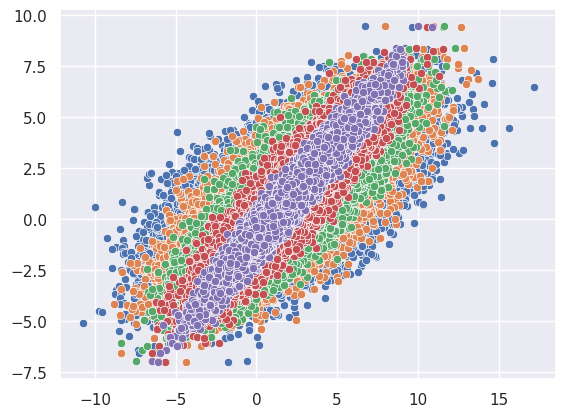

In [58]:
seed_everything()
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

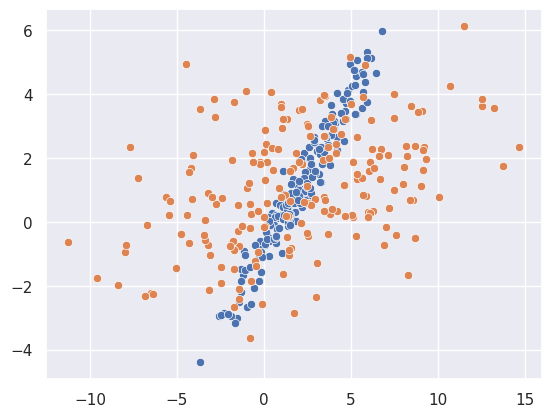

In [59]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## Mutual Information의 측정

In [60]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [61]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.810444
x2    0.512920
x1    0.350373
z0    0.255009
x0    0.238650
Name: MI Scores, dtype: float64


### Bucket 별 MI 측정

+ Bucket을 10, 50, 100 으로 나눠서

Bucket size 10


100%|██████████| 10/10 [00:01<00:00,  9.07it/s]


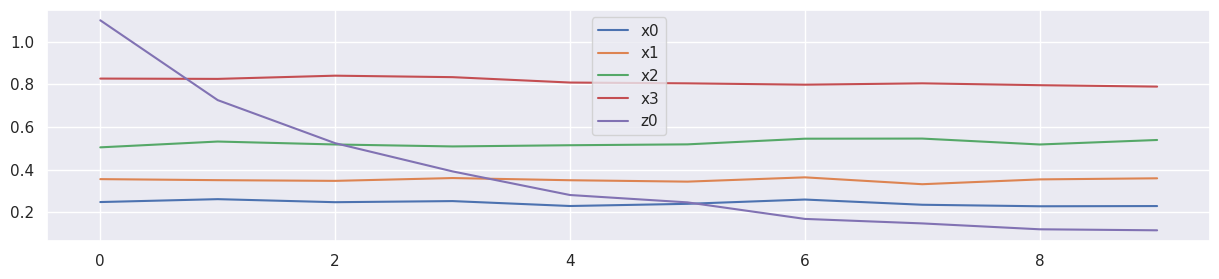

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 40.03it/s]


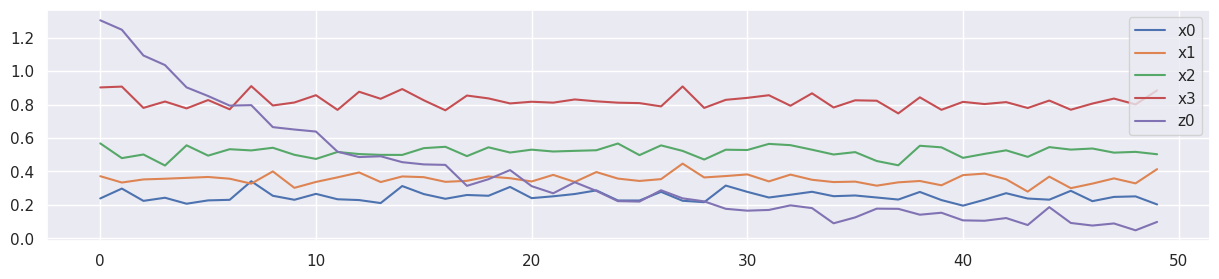

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 61.51it/s]


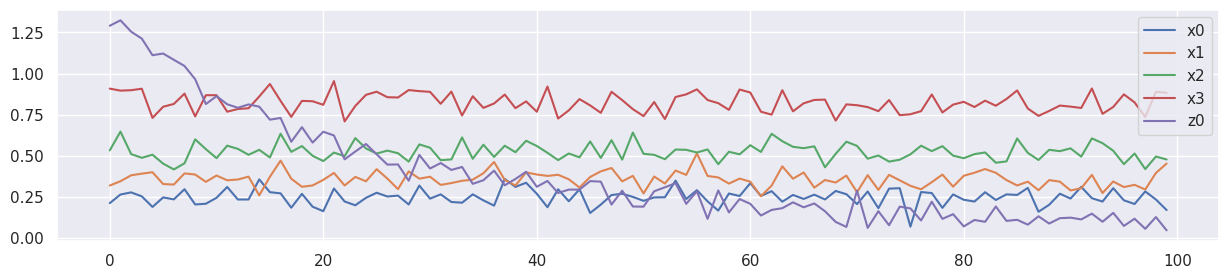

Bucket size 200


100%|██████████| 200/200 [00:02<00:00, 85.69it/s]


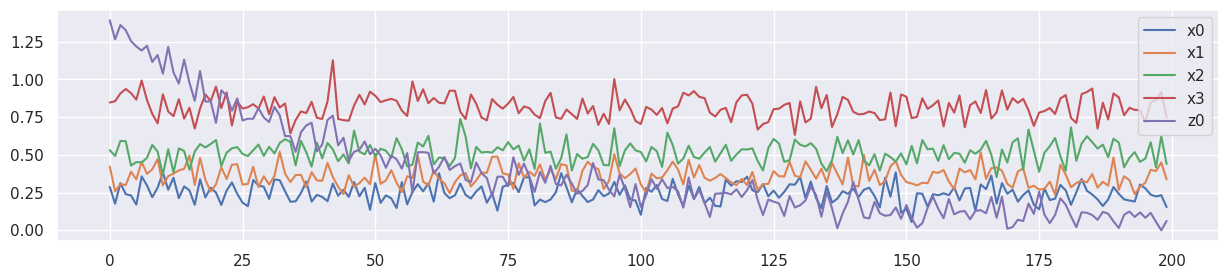

In [62]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 MI는 bucket의 증가에 따라, 낮아지는 것을 확인할 수 있다.

# Deep architecture에 의한 y의 추정 실험

+ 2000개를 학습하고, 이후 38000개를 추정한다.

## 학습데이터, 2000개 내 bucket 20개의 importance 변화

100%|██████████| 20/20 [00:00<00:00, 95.58it/s]


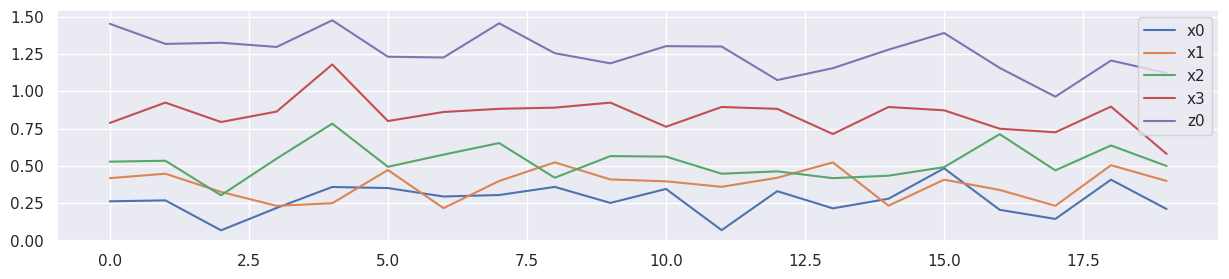

In [63]:
MIS = {}
for col in columns:
    MIS[col] = []
        
for bk in tqdm(range(20)):
    bx = X[bk*100:(bk+1)*100]
    by = y[bk*100:(bk+1)*100]
    mi_scores = make_mi_scores(bx, by, discrete_features="auto")
    for col in columns:
        MIS[col].append(mi_scores[col]) 

df_mis = pd.DataFrame(MIS)
df_mis.plot(figsize=(15,3))
plt.show()

## feature 5개를 모두 포함한 학습

100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


MSE: 0.26
RMSE: 0.51


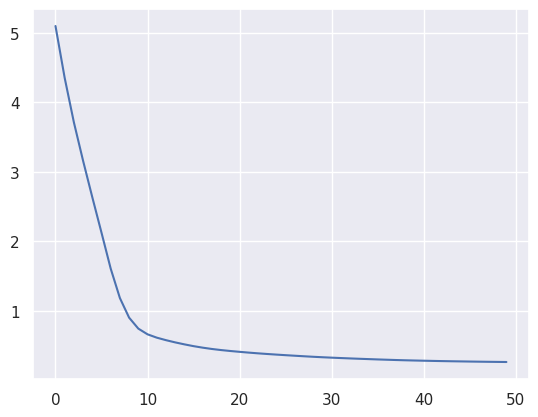

In [85]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

+ R2 측정

In [86]:
from sklearn.metrics import r2_score
predicted_y = model(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9366162758893165


+ 2000~40000까지의 R-squared score 측정 

100%|██████████| 190/190 [00:00<00:00, 1539.78it/s]


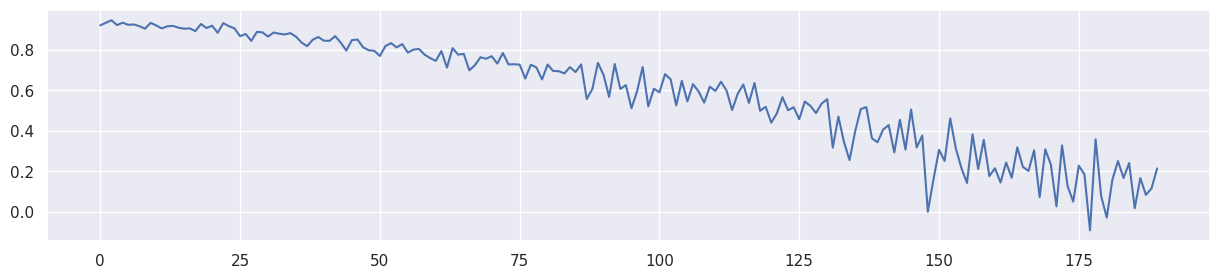

Mean R2 for all data: 0.589717790270235


In [89]:
XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    r2s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        r2s.append(r2)
    plt.figure(figsize=(15,3))
    plt.plot(r2s)
    plt.show()
print('Mean R2 for all data:',np.mean(r2s))

## feature 5개 + bucket(B) = feature 6개를 학습

In [90]:
# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

,x0,x1,x2,x3,z0,b
0,3.556141,0.941507,3.437163,1.999518,2.294869,0
1,3.339511,4.937466,5.067007,5.374971,4.633732,0
2,3.386047,6.549118,5.827483,3.318762,4.220318,0
3,3.692233,-1.647118,0.442510,0.955679,0.275325,0
4,4.247477,4.661680,2.175405,2.502366,3.314767,0
...,...,...,...,...,...,...
39995,-1.286782,-2.381539,1.116737,1.476795,-1.939322,399
39996,0.732667,-1.418612,1.156944,1.757167,3.661968,399
39997,1.065551,4.673373,4.232410,3.482673,3.469058,399
39998,2.783400,-0.883189,-0.888540,3.373605,10.055974,399


100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


MSE: 0.24
RMSE: 0.49


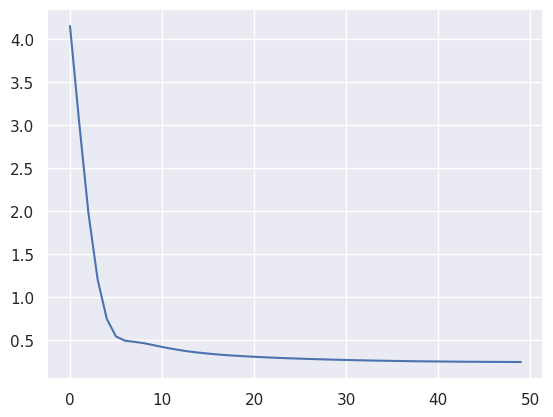

In [91]:
seed_everything()

X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(6, 24),
    nn.ReLU(),
    nn.Linear(24, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [92]:
from sklearn.metrics import r2_score
predicted_y = model(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9415254556615077


100%|██████████| 190/190 [00:00<00:00, 1367.21it/s]


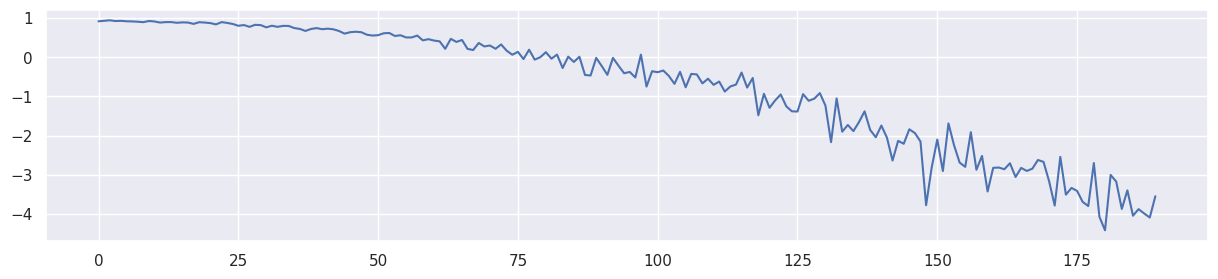

Mean R2 for all data: -0.7502214641280646


In [93]:
XT = X[2000:]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    r2s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        r2s.append(r2)
    plt.figure(figsize=(15,3))
    plt.plot(r2s)
    plt.show()

print('Mean R2 for all data:',np.mean(r2s))

## z0를 빼고, 4개 feature로 학습

100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


MSE: 0.61
RMSE: 0.78


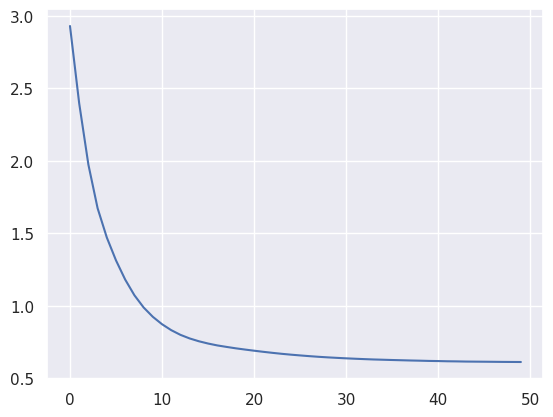

In [95]:
seed_everything()

X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10 # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [96]:
from sklearn.metrics import r2_score
predicted_y = model(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.8516901390225248


100%|██████████| 190/190 [00:00<00:00, 1460.16it/s]


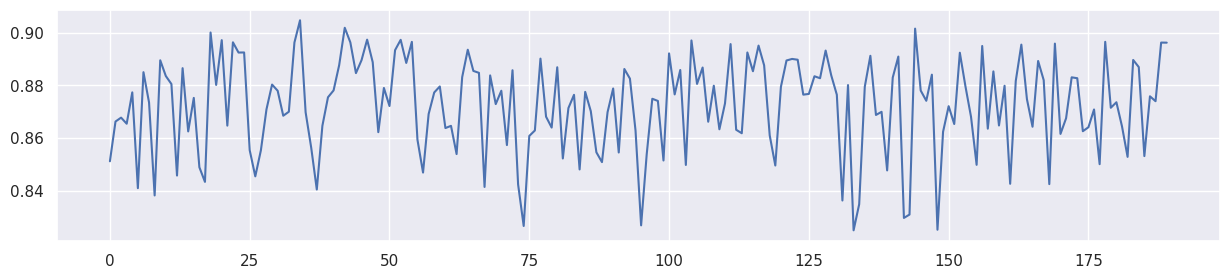

Mean R2 for all data: 0.8724721800508857


In [99]:
XT = X[2000:][['x0','x1','x2','x3']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    r2s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        r2s.append(r2)
    plt.figure(figsize=(15,3))
    plt.plot(r2s)
    plt.show()

print('Mean R2 for all data:',np.mean(r2s))   

+ 위에서 보면.... 학습과정에서, 현재는 학습에 효과가 있지만 향후 잠재적으로 성능을 저해할 수 있는 feature를 탐지하여 이의 효과를 경감 또는 (보정) 할 수 있는 학습 방법을 찾아야 하는 것!!!

## RF-Train의 적용

+ 위의 데이터에서, sensitive attribute는 z0에 대당된다.
+ 따라서, MI(y^|z0) = 0 이되어야 하고,
+ Fairness discriminator에서는  Y^과 z0의 loss가 커야 한다! 즉, 최대한 상관 없어야 한다.
+ OK, 일단 이렇게 구성해 본다!

In [74]:
!git clone https://github.com/yuji-roh/fr-train.git

Cloning into 'fr-train'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 9), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 168.32 KiB | 458.00 KiB/s, done.


In [75]:
%cd fr-train
!pwd

/content/fr-train/fr-train
/content/fr-train/fr-train


In [76]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

+ Generator의 구현 = 위에서 feature 5개의 model과 동일
+ DiscriminatorF = Y^과 z0가 같아지지 않게 학습 ??

In [77]:

def test_model(model_, tX, ty, s1):
    """Tests the performance of a model.

    Args:
        model_: A model to test.
        X: Input features of test data.
        y: True label (1-D) of test data.
        s1: Sensitive attribute (1-D) of test data.

    Returns:
        The test accuracy and disparate impact of the model.
    """
    
    model_.eval()
    
    y_hat = model_(tX).squeeze().detach().numpy()

    r2 = r2_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test R-squared score: {}".format(r2))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return r2, mi

In [78]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output

# DiscriminatorF
# regression, Y^과 z0가 같아지지 않게 학습...??? (이거 쫌 아리까리!)
class DiscriminatorF(nn.Module):
    """FR-Train fairness discriminator.
    
    This class is for defining structure of FR-Train fairness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(DiscriminatorF, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 1)
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted sensitive attribute for the given input data.
        """
        
        predicted_z = self.model(input_data)
        return predicted_z
    

In [118]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = mse_loss(gen_y, y_train.reshape(-1,1))
        g_loss.backward()
        g_losses.append(g_loss)
        optimizer_G.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    tmp = test_model(generator, XS_test, y_test, s1_test)
    test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return test_result, generator

In [117]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()

        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss)
        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------
        optimizer_D_F.zero_grad()
        # Discriminator_F tries to distinguish the sensitive groups by using the output of the generator.
        d_f_loss = mse_loss(discriminator_F(gen_y.detach()), s1_train.reshape(-1,1))
        #d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        #optimizer_D_F.step()
        
        loss = (1-lambda_f) * g_loss - lambda_f * d_f_loss 

        loss.backward()
        optimizer_G.step()
        optimizer_D_F.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    tmp = test_model(generator, XS_test, y_test, s1_test)
    test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return test_result,generator

In [122]:
def test_all_data(generator):

    XT = X[2000:][['x0','x1','x2','x3','z0']]
    yT = y[2000:]

    bucket_size_array=[200]

    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)
        r2s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
            predicted_y = generator(tmp_x)
            r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            r2s.append(r2)
        plt.figure(figsize=(15,3))
        plt.plot(r2s)
        plt.show()

    print('Mean R2 for all data:',np.mean(r2s))   
    return r2s

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 5.344502]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 4.436438]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 3.057725]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 1.898989]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 1.257700]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.927270]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.699251]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.566841]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.492037]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.442835]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.405045]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.373670]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.346869]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.324071]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.304888]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.288725]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.274406]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.261586]

100%|██████████| 190/190 [00:00<00:00, 1532.99it/s]


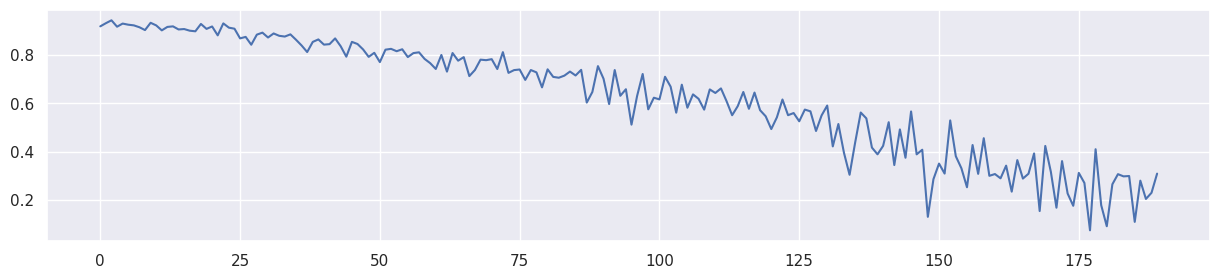

Mean R2 for all data: 0.624882232547598
[Lambda: 0.100000] [Epoch 0/4000] [D_F loss: 8.636786] [G loss: 0.000005]
[Lambda: 0.100000] [Epoch 200/4000] [D_F loss: 9.373638] [G loss: 0.000005]
[Lambda: 0.100000] [Epoch 400/4000] [D_F loss: 10.793739] [G loss: 0.000003]
[Lambda: 0.100000] [Epoch 600/4000] [D_F loss: 13.492980] [G loss: 0.000002]
[Lambda: 0.100000] [Epoch 800/4000] [D_F loss: 18.563187] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1000/4000] [D_F loss: 26.771566] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1200/4000] [D_F loss: 38.630432] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1400/4000] [D_F loss: 55.620663] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1600/4000] [D_F loss: 80.922668] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1800/4000] [D_F loss: 120.364548] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 2000/4000] [D_F loss: 180.502518] [G loss: 0.000000]
[Lambda: 0.100000] [Epoch 2200/4000] [D_F loss: 271.801849] [G loss: 0.000000]
[Lambda: 0.100000] [Epoch 2400

100%|██████████| 190/190 [00:00<00:00, 1626.04it/s]


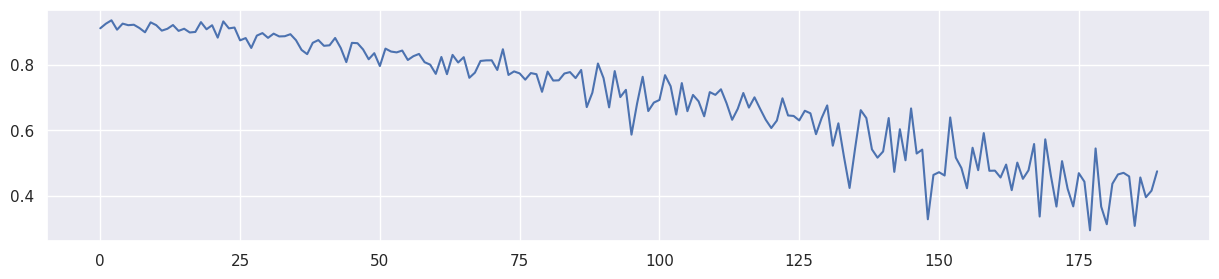

Mean R2 for all data: 0.6975113307530553
[Lambda: 0.200000] [Epoch 0/4000] [D_F loss: 8.636786] [G loss: 0.000005]
[Lambda: 0.200000] [Epoch 200/4000] [D_F loss: 9.772216] [G loss: 0.000005]
[Lambda: 0.200000] [Epoch 400/4000] [D_F loss: 12.023879] [G loss: 0.000003]
[Lambda: 0.200000] [Epoch 600/4000] [D_F loss: 17.281775] [G loss: 0.000002]
[Lambda: 0.200000] [Epoch 800/4000] [D_F loss: 30.491945] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1000/4000] [D_F loss: 60.975166] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1200/4000] [D_F loss: 125.123146] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1400/4000] [D_F loss: 257.483093] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1600/4000] [D_F loss: 536.713501] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1800/4000] [D_F loss: 1159.327881] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 2000/4000] [D_F loss: 2560.759277] [G loss: 0.000000]
[Lambda: 0.200000] [Epoch 2200/4000] [D_F loss: 5726.244629] [G loss: 0.000000]
[Lambda: 0.200000] [Epo

100%|██████████| 190/190 [00:00<00:00, 1603.36it/s]


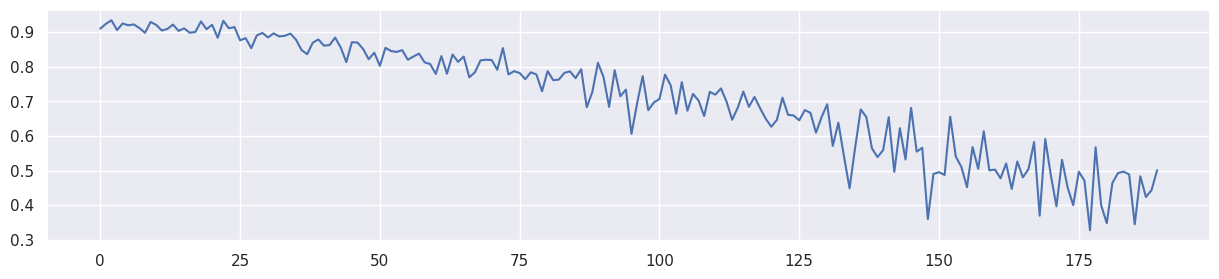

Mean R2 for all data: 0.7104762676326617
[Lambda: 0.300000] [Epoch 0/4000] [D_F loss: 8.636786] [G loss: 0.000005]
[Lambda: 0.300000] [Epoch 200/4000] [D_F loss: 10.202448] [G loss: 0.000005]
[Lambda: 0.300000] [Epoch 400/4000] [D_F loss: 13.464752] [G loss: 0.000003]
[Lambda: 0.300000] [Epoch 600/4000] [D_F loss: 22.323339] [G loss: 0.000002]
[Lambda: 0.300000] [Epoch 800/4000] [D_F loss: 50.375610] [G loss: 0.000002]
[Lambda: 0.300000] [Epoch 1000/4000] [D_F loss: 138.673599] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 1200/4000] [D_F loss: 402.421692] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 1400/4000] [D_F loss: 1180.357178] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 1600/4000] [D_F loss: 3509.371826] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 1800/4000] [D_F loss: 10887.119141] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 2000/4000] [D_F loss: 35148.390625] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 2200/4000] [D_F loss: 115943.218750] [G loss: 0.000000]
[Lambda: 0.3000

100%|██████████| 190/190 [00:00<00:00, 1541.53it/s]


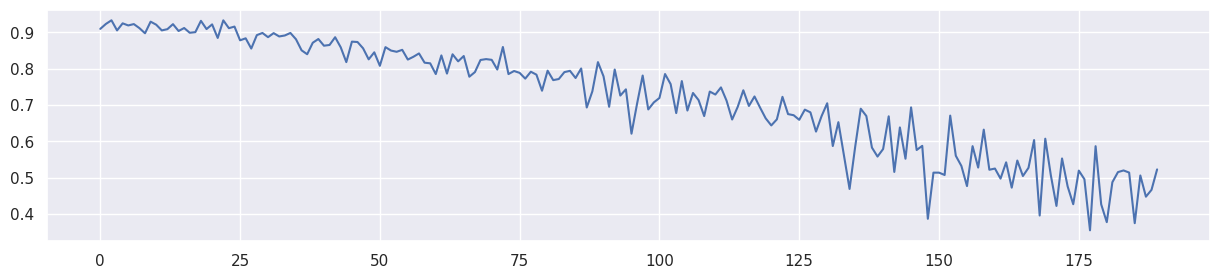

Mean R2 for all data: 0.7213370432726145
[Lambda: 0.400000] [Epoch 0/4000] [D_F loss: 8.636786] [G loss: 0.000005]
[Lambda: 0.400000] [Epoch 200/4000] [D_F loss: 10.666074] [G loss: 0.000005]
[Lambda: 0.400000] [Epoch 400/4000] [D_F loss: 15.144817] [G loss: 0.000003]
[Lambda: 0.400000] [Epoch 600/4000] [D_F loss: 28.966297] [G loss: 0.000002]
[Lambda: 0.400000] [Epoch 800/4000] [D_F loss: 82.978844] [G loss: 0.000002]
[Lambda: 0.400000] [Epoch 1000/4000] [D_F loss: 311.559479] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 1200/4000] [D_F loss: 1272.116821] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 1400/4000] [D_F loss: 5305.152344] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 1600/4000] [D_F loss: 22482.130859] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 1800/4000] [D_F loss: 99287.914062] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 2000/4000] [D_F loss: 462731.125000] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 2200/4000] [D_F loss: 2237657.750000] [G loss: 0.000000]
[Lambda: 0.

100%|██████████| 190/190 [00:00<00:00, 1545.28it/s]


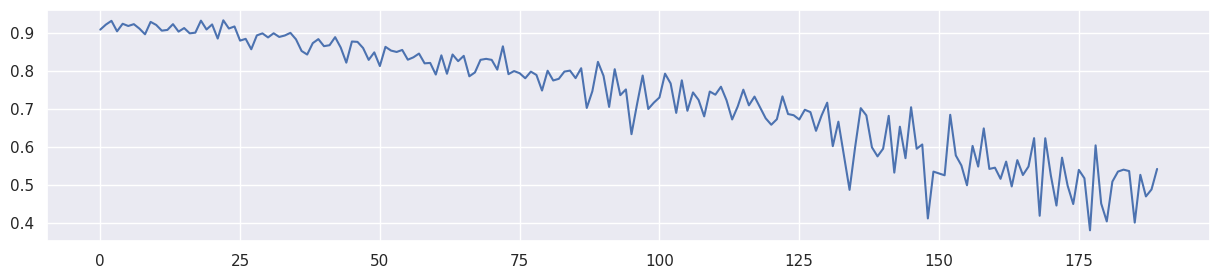

Mean R2 for all data: 0.7304580828831112
[Lambda: 0.500000] [Epoch 0/4000] [D_F loss: 8.636786] [G loss: 0.000005]
[Lambda: 0.500000] [Epoch 200/4000] [D_F loss: 11.164457] [G loss: 0.000005]
[Lambda: 0.500000] [Epoch 400/4000] [D_F loss: 17.088676] [G loss: 0.000003]
[Lambda: 0.500000] [Epoch 600/4000] [D_F loss: 37.577202] [G loss: 0.000002]
[Lambda: 0.500000] [Epoch 800/4000] [D_F loss: 135.125168] [G loss: 0.000002]
[Lambda: 0.500000] [Epoch 1000/4000] [D_F loss: 685.301880] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 1200/4000] [D_F loss: 3920.370605] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 1400/4000] [D_F loss: 23203.292969] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 1600/4000] [D_F loss: 140437.234375] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 1800/4000] [D_F loss: 877421.062500] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 2000/4000] [D_F loss: 5811389.000000] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 2200/4000] [D_F loss: 40712120.000000] [G loss: 0.000000]
[Lamb

100%|██████████| 190/190 [00:00<00:00, 1594.05it/s]


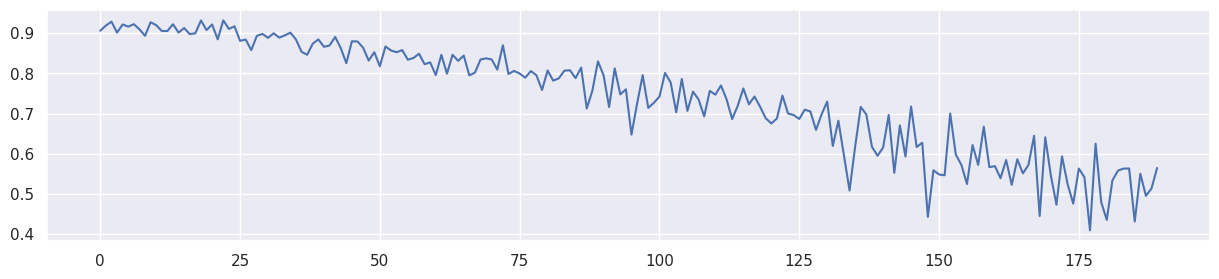

Mean R2 for all data: 0.7418318877433391
[Lambda: 0.600000] [Epoch 0/4000] [D_F loss: 8.636786] [G loss: 0.000005]
[Lambda: 0.600000] [Epoch 200/4000] [D_F loss: 11.697756] [G loss: 0.000005]
[Lambda: 0.600000] [Epoch 400/4000] [D_F loss: 19.306597] [G loss: 0.000003]
[Lambda: 0.600000] [Epoch 600/4000] [D_F loss: 48.413933] [G loss: 0.000002]
[Lambda: 0.600000] [Epoch 800/4000] [D_F loss: 214.995041] [G loss: 0.000002]
[Lambda: 0.600000] [Epoch 1000/4000] [D_F loss: 1455.481201] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 1200/4000] [D_F loss: 11615.822266] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 1400/4000] [D_F loss: 97286.992188] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 1600/4000] [D_F loss: 838077.875000] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 1800/4000] [D_F loss: 7428146.000000] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 2000/4000] [D_F loss: 69132440.000000] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 2200/4000] [D_F loss: 684908416.000000] [G loss: 0.000001]


100%|██████████| 190/190 [00:00<00:00, 1605.41it/s]


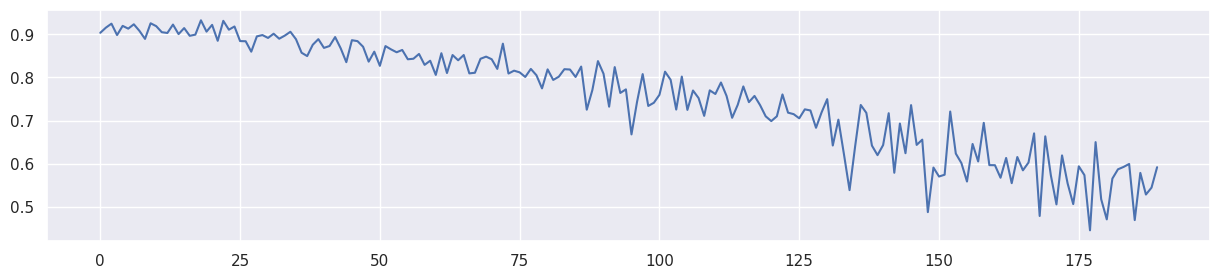

Mean R2 for all data: 0.7569188396969035
[Lambda: 0.700000] [Epoch 0/4000] [D_F loss: 8.636786] [G loss: 0.000005]
[Lambda: 0.700000] [Epoch 200/4000] [D_F loss: 12.263242] [G loss: 0.000005]
[Lambda: 0.700000] [Epoch 400/4000] [D_F loss: 21.764053] [G loss: 0.000003]
[Lambda: 0.700000] [Epoch 600/4000] [D_F loss: 61.211952] [G loss: 0.000002]
[Lambda: 0.700000] [Epoch 800/4000] [D_F loss: 326.627289] [G loss: 0.000002]
[Lambda: 0.700000] [Epoch 1000/4000] [D_F loss: 2894.431152] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 1200/4000] [D_F loss: 32002.617188] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 1400/4000] [D_F loss: 377915.812500] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 1600/4000] [D_F loss: 4607161.500000] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 1800/4000] [D_F loss: 57970792.000000] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 2000/4000] [D_F loss: 756284224.000000] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 2200/4000] [D_F loss: 10371066880.000000] [G loss: 0.00

100%|██████████| 190/190 [00:00<00:00, 1506.33it/s]


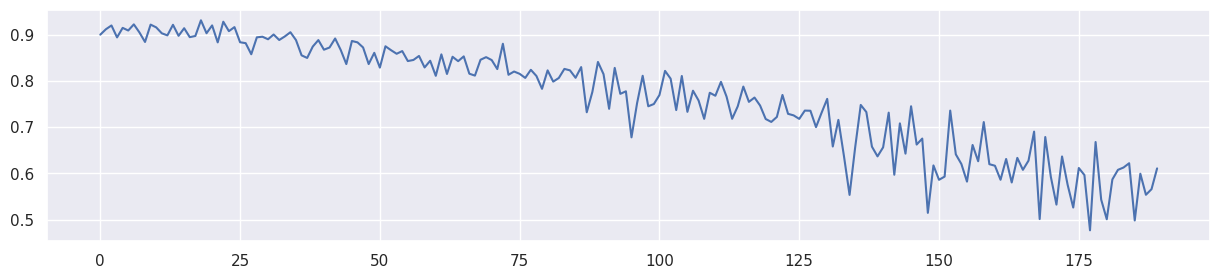

Mean R2 for all data: 0.7653326618209052
[Lambda: 0.800000] [Epoch 0/4000] [D_F loss: 8.636786] [G loss: 0.000005]
[Lambda: 0.800000] [Epoch 200/4000] [D_F loss: 12.849540] [G loss: 0.000005]
[Lambda: 0.800000] [Epoch 400/4000] [D_F loss: 24.284874] [G loss: 0.000004]
[Lambda: 0.800000] [Epoch 600/4000] [D_F loss: 73.830116] [G loss: 0.000002]
[Lambda: 0.800000] [Epoch 800/4000] [D_F loss: 446.038116] [G loss: 0.000002]
[Lambda: 0.800000] [Epoch 1000/4000] [D_F loss: 4934.170898] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 1200/4000] [D_F loss: 74133.375000] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 1400/4000] [D_F loss: 1228877.375000] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 1600/4000] [D_F loss: 21069316.000000] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 1800/4000] [D_F loss: 370773184.000000] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 2000/4000] [D_F loss: 6741339136.000000] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 2200/4000] [D_F loss: 127504891904.000000] [G loss:

100%|██████████| 190/190 [00:00<00:00, 1492.28it/s]


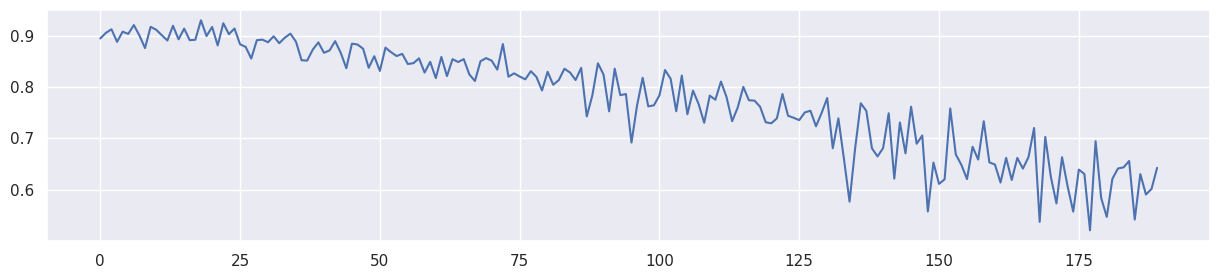

Mean R2 for all data: 0.777411688466504
[Lambda: 0.900000] [Epoch 0/4000] [D_F loss: 8.636786] [G loss: 0.000005]
[Lambda: 0.900000] [Epoch 200/4000] [D_F loss: 13.413482] [G loss: 0.000005]
[Lambda: 0.900000] [Epoch 400/4000] [D_F loss: 26.154530] [G loss: 0.000004]
[Lambda: 0.900000] [Epoch 600/4000] [D_F loss: 77.137802] [G loss: 0.000003]
[Lambda: 0.900000] [Epoch 800/4000] [D_F loss: 433.591583] [G loss: 0.000002]
[Lambda: 0.900000] [Epoch 1000/4000] [D_F loss: 4916.249023] [G loss: 0.000002]
[Lambda: 0.900000] [Epoch 1200/4000] [D_F loss: 89951.859375] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 1400/4000] [D_F loss: 2020377.625000] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 1600/4000] [D_F loss: 48471328.000000] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 1800/4000] [D_F loss: 1190033408.000000] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 2000/4000] [D_F loss: 29646032896.000000] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 2200/4000] [D_F loss: 750318125056.000000] [G loss

100%|██████████| 190/190 [00:00<00:00, 1595.79it/s]


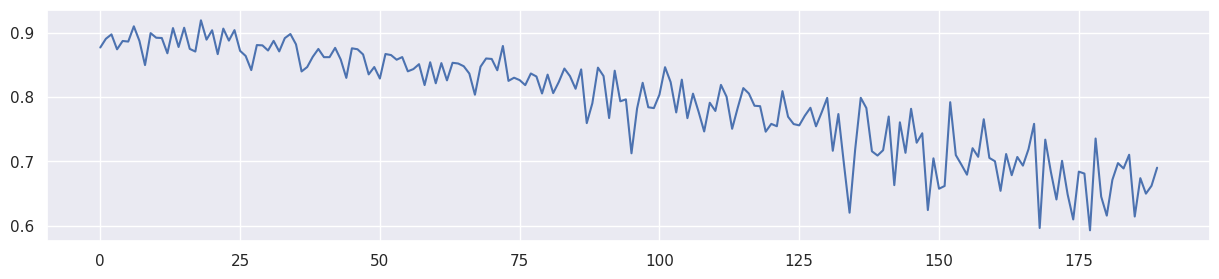

Mean R2 for all data: 0.7931574135754563


<Axes: >

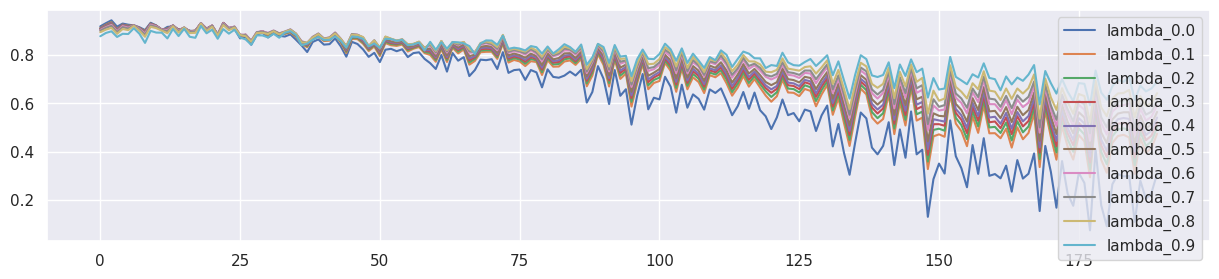

In [125]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        result, last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        train_result.append(result)
    else:
        result, last_generator= train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        train_result.append(result)

resilt_df = pd.DataFrame(result_table)
resilt_df.plot(figsize=(15,3))

